# Deep MIMO Detection

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* Implementation and optimization of the deep MIMO detector *DetNet* introduced by [1]. This code implements *DetNet* closely to [1].

[1] N. Samuel, T. Diskin and A. Wiesel, "Deep MIMO detection," 2017 IEEE 18th International Workshop on Signal Processing Advances in Wireless Communications (SPAWC), Sapporo, 2017, pp. 1-5.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


Our goal is to do a binary MIMO detection with a deep neural network as it is proposed in [1]. 
Given is a $K \times N$ MIMO channel. The channel matrix $\mathbf{H}$ is varying for each sample and is known to the detector. After applying AWGN, the detector receives the signal and detects the data bits.
The optimal **maximum likelihood detector** has a too high worst case computational complexity and is therefore impractical for many applications [1]. Existing suboptimal MIMO detectors are e.g. zero forcing, minimum mean squared error or the matched filter. The idea is, that a deep neural network gains better performance than the so far known suboptimal detectors without getting too computationally complex.

Lets first define our MIMO channel and generate data. 

In [ ]:
# MIMO channel config
K = 30  # Tranmit antennas.
N = 60  # Receive antennas.
snr = 10.0  # SNR of channel in dB for the training.
snr_lin = 10.0 ** (snr/10.0)  # SNR of channel in lin.

# case VC: Varying channel (randomly generated channel matrix for each new sample).

# Function for training and test data generation according to the FC model of the paper.
def data_generation_VC(K, N, size, snr, snr_var, device):
    t = np.random.randint(2, size=(size, K))*2.0-1 # Random binary TX symbols.
    n = np.random.randn(size, N) # Random noise for each RX antenna.
    r = np.empty(shape=[size, N]) # RX dummy vector
    Hr = np.empty(shape=[size, K])
    HH = np.zeros([size, K, K])
    # Randomly vary the SNR
    current_snr = 10.0 ** (np.random.uniform(low=snr-snr_var,high=snr+snr_var, size=size)/10.0)
    for i in range(size):
        H = np.random.randn(N, K)*1.0/np.sqrt(N)  # Generate random and normalized channel.
        HH[i,:,:] = H.T.dot(H) # Calc (H^T H) as it is used as an input for the neural net.
        # Calc the output vector with additive noise which depends on the current SNR.
        r[i,:] = (H.dot(t[i,:])+n[i,:]*np.sqrt((HH[i,:,:]).trace()/K)/np.sqrt(current_snr[i]))
        Hr[i,:] = H.T.dot(r[i,:]) # Calc (H^T y) as it is used as an input for the neural net.
    t = torch.Tensor(t).to(device)
    Hr = torch.Tensor(Hr).to(device)
    HH = torch.Tensor(HH).to(device)
    return r, Hr, HH, current_snr, t

Configure and build the neural network.
Each layer has the 4 inputs $\mathbf{H}^{T}\mathbf{r}$, $\mathbf{H}^{T}\mathbf{H}$, $\mathbf{t}_k$ and $\mathbf{v}_k$. The index $k$ denotes the layer. The layers can also be interpreted as iterations of an optimization algorithm [1].

The nonlinear operation
$
\begin{align*}
&\quad z_{k} = \rho\left(\text{W}_{1k}\begin{bmatrix}
\mathbf{H}^{T}\mathbf{r}\\
\hat{\mathbf{t}}_{k}\\
\mathbf{H}^{T}\mathbf{H}\hat{\text{t}}_{k}\\
\mathbf{v}_{k}
\end{bmatrix}+\mathbf{b}_{1k}\right)\\
&\hat{\mathbf{t}}_{k+1} = \psi_{t_{k}}(\mathbf{W}_{2k}\mathbf{z}_{k}+\mathbf{b}_{2k})\\
&\hat{\mathbf{v}}_{k+1} = \mathbf{W}_{3k}\mathbf{z}_{k}+\mathbf{b}_{3k}\\
&\qquad\hat{\mathbf{t}}_{1} = \mathbf{0}\tag{10}
\end{align*}
$
is applied to the input. $\mathbf{t}_0$ is the received data vector.

Summarized, each layer does roughly the following steps:
* Concatenate the inputs.
* Linear transformation.
* Apply ReLU function.
* Calculate $\mathbf{v}_{k+1}$ as a linear trafo of the ReLU output and use ResNet feature.
* Calculate $\hat{\mathbf{t}}_{k+1}$ as a linear trafo of the ReLU output which is then fed to the linear soft sign function.


In [ ]:
# DetNet config
layers = 3*K
v_len = 2*K
z_len = 8*K

# Training params
training_steps = 10000
batch_size_train = 5000
snr_var_train = 3.0 # Maximum absolute deviation of the SNR from its mean in logarithmic scale.

# Test params
test_steps= 1000
batch_size_test = 5000
snr_range = np.arange(8, 14, 1)

# Definition of the Loss function
def own_loss(t, t_train, t_ZF):
    loss_l = torch.zeros(len(t), 1, device=device)        # Denotes the loss in Layer L
    for layer in range(1,len(t)+1):
        loss_l[layer-1] = torch.log(torch.Tensor([layer+1]).to(device))*torch.mean(torch.mean(torch.square(t_train - t[layer-1]),1)/torch.mean(torch.square(t_train - t_ZF),1))
    return loss_l
     

# Definition of the DetNet
class DetNet(nn.Module):
    # Build DetNet
    def __init__(self, layers, K, v_len, z_len):
        # Here we define the trainable parameter (Net)
        super(DetNet, self).__init__()
        # We have to use here nn.ModuleList instead of a PythonList. (Otherwise you’ll get an error saying
        # that your model has no parameters, because PyTorch does not see the parameters of the layers stored
        # in a Python list)
        # Furtheremore, we initialize the linear trafo with normailzed weights
        # Linear Traffos W_1l, W_2l, W_3l
        self.linear_trafo_1_l = nn.ModuleList()
        self.linear_trafo_1_l.extend([nn.Linear(3*K + v_len, z_len) for i in range(1, layers+1)])
        for i in range(0, layers):
            nn.init.normal_(self.linear_trafo_1_l[i].weight, std = 0.01)
            nn.init.normal_(self.linear_trafo_1_l[i].bias, std = 0.01)
        self.linear_trafo_2_l = nn.ModuleList()
        self.linear_trafo_2_l.extend([nn.Linear(z_len, K) for i in range(1, layers+1)])
        for i in range(0, layers):
            nn.init.normal_(self.linear_trafo_2_l[i].weight, std = 0.01)
            nn.init.normal_(self.linear_trafo_2_l[i].bias, std = 0.01)
        self.linear_trafo_3_l = nn.ModuleList()
        self.linear_trafo_3_l.extend([nn.Linear(z_len , v_len) for i in range(1, layers+1)])
        for i in range(0, layers):
            nn.init.normal_(self.linear_trafo_3_l[i].weight, std = 0.01)
            nn.init.normal_(self.linear_trafo_3_l[i].bias, std = 0.01)
        # For Linear Soft Sign function        
        self.kappa_l = nn.ParameterList()
        self.kappa_l.extend([nn.Parameter(torch.rand(1, requires_grad=True, device=device)) for i in range(1, layers+1)])
        # ReLU as activation faunction
        self.relu = nn.ReLU()
            
    def forward(self, Hr, HH):
        v = torch.zeros(len(Hr), v_len, device=device)   # Internal Memory (state), that is passed to the next layer
        t = torch.zeros(1, len(Hr), K, device=device)    # Transmit vector we want to estimate -> Initalizied as zero
        t_tilde = torch.zeros(len(Hr), K, device=device)    # Transmit vector we want to estimate -> Initalizied as zero
        
        # Send Data through the staced DetNet
        for l in range(1,layers+1):
            # Concatenate the 4 inputs Hy, v, x and HH.
            concat = torch.cat((Hr, v, t[-1,:,:], torch.squeeze(torch.matmul(torch.unsqueeze(t[-1,:,:], 1), HH))), 1)
            
            # Apply linear transformation and rectified linear unit (ReLU).
            z = self.relu(self.linear_trafo_1_l[l-1](concat))               
                
            # Generate new t iterate with a final linear trafo.
            t_tilde = self.linear_trafo_2_l[l-1](z)
            t = torch.cat((t, torch.unsqueeze(-1+self.relu(t_tilde+self.kappa_l[l-1])/torch.abs(self.kappa_l[l-1])-self.relu(t_tilde-self.kappa_l[l-1])/torch.abs(self.kappa_l[l-1]),0)), 0)
            
            # Generate new v iterate with a final linear trafo.
            v = self.linear_trafo_3_l[l-1](z)
            del concat, z
            torch.cuda.empty_cache()
        del v, t_tilde
        torch.cuda.empty_cache()
        return t[1:,:,:]

Training of the network.
The loss function takes into account the output of all the layers $\mathcal{L}$ and is normalized to the loss of a zero forcing equalizer $\Vert \mathbf{t}-\tilde{\mathbf{t}}\Vert^{2}$. The loss function is defined as:
\begin{align*}
&L(\mathbf{t};\hat{\mathbf{t}}_{\theta}(\mathbf{H}, \mathbf{r}))=\sum_{k=l}^{\mathcal{L}}\log(l)\frac{\Vert \mathbf{t}^{[train]}-\hat{\mathbf{t}}_{l}\Vert ^{2}}{\Vert \mathbf{t}^{[train]}-\hat{\mathbf{t}}_{ZF}\Vert^{2}},\tag{13}\\
\text{where}:\\
&\qquad\qquad \hat{\mathbf{t}}_{ZF}=(\mathbf{H}^{T}\mathbf{H})^{-1}\mathbf{H}^{T}\mathbf{r}.
\tag{14}
\end{align*}
is the estimated transmit vector of the ZF decoder

In [ ]:
model = DetNet(layers, K, v_len, z_len)
model.to(device)

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), eps=1e-07)

results = []
ber = []


for i in range(training_steps):
    # Generate a batch of training data.
    r_train, Hr_train, HH_train, snr_train, t_train = data_generation_VC(K, N, batch_size_train, snr, snr_var_train, device)
    
    # Feed the training data to network and update weights.   
    t = model(Hr_train, HH_train)
    
    # compute loss
    # Calculate optimal decorrelation decoder to normalize the loss function later on.
    t_ZF = torch.squeeze(torch.matmul(torch.unsqueeze(Hr_train,1),torch.inverse(HH_train)), 1)
    loss = torch.sum(own_loss(t, t_train, t_ZF))
    
    # compute gradients
    loss.backward()

    # Adapt weights
    optimizer.step()

    # reset gradients
    optimizer.zero_grad()
    
    # Print the current progress of the training (Loss and BER).
    # Pay attention that we are print the Loss/BER on the Trainings-Dataset.
    # For a real evaulation of the model we should test the model on the test dataset
    if i%500 == 0:       
        results.append(own_loss(t, t_train, t_ZF).detach().cpu().numpy())
        ber.append(1 - torch.mean(t_train.eq(torch.sign(t)).float(),[1,2]).detach().cpu().numpy())
        print('Train step ', i, ', current loss: ', results[-1][-1], ', current ber: ', ber[-1][-1])
    del r_train, Hr_train, HH_train, snr_train, t_train, t
    torch.cuda.empty_cache()
    
# # Save the trained model
# torch.save(model.state_dict(), 'Deep_MIMO_Detection_net')

Train step  0 , current loss:  [27.100454] , current ber:  0.49936664
Train step  500 , current loss:  [0.31468442] , current ber:  0.005973339
Train step  1000 , current loss:  [0.28869316] , current ber:  0.005800009
Train step  1500 , current loss:  [0.3112602] , current ber:  0.0058933496
Train step  2000 , current loss:  [0.2852565] , current ber:  0.0057799816
Train step  2500 , current loss:  [0.29907122] , current ber:  0.0060866475
Train step  3000 , current loss:  [0.291224] , current ber:  0.005800009
Train step  3500 , current loss:  [0.31644815] , current ber:  0.0062733293
Train step  4000 , current loss:  [0.30326983] , current ber:  0.0058733225
Train step  4500 , current loss:  [0.29673994] , current ber:  0.0058666468
Train step  5000 , current loss:  [0.28455204] , current ber:  0.005546689
Train step  5500 , current loss:  [0.30418554] , current ber:  0.005733311
Train step  6000 , current loss:  [0.29058623] , current ber:  0.006039977
Train step  6500 , current lo

### Visualize 

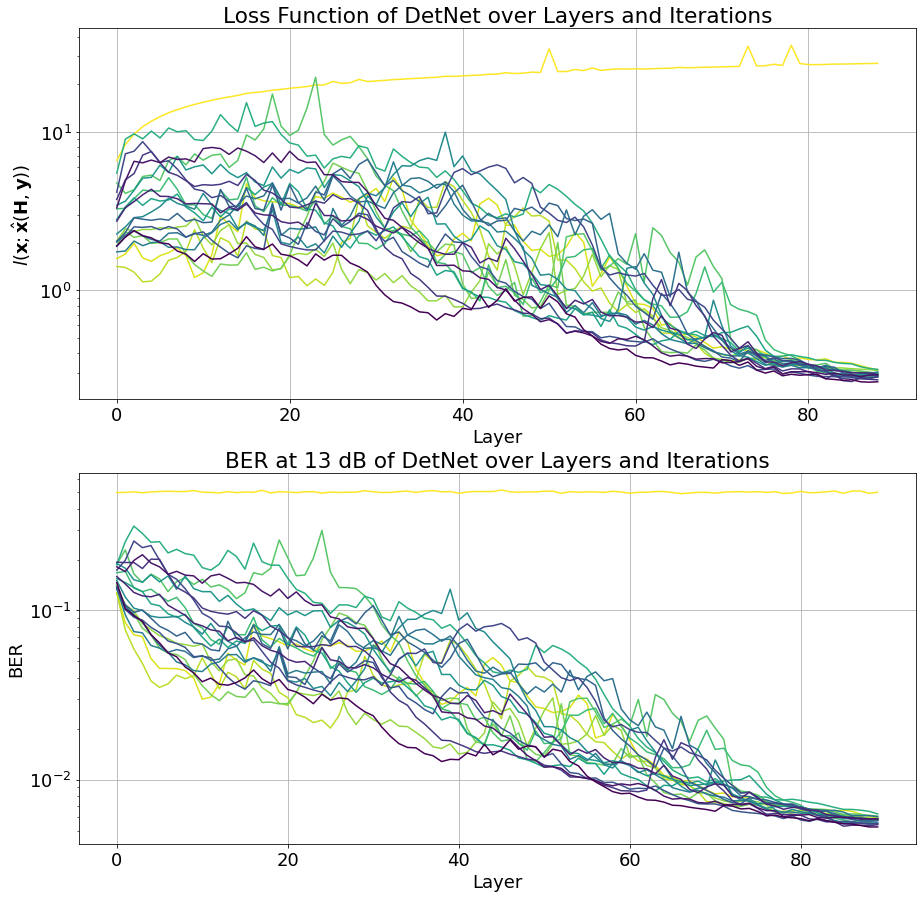

In [ ]:
fig = plt.figure(1,figsize=(15,15))
plt.rcParams.update({'font.size': 18})
color=iter(cm.viridis_r(np.linspace(0,1,len(results))))
# Plot loss.
plt.subplot(211)
for i in range(0, len(results)):
    c=next(color)
    plt.semilogy(range(0, len(results[0])-1), results[i][1:], color=c)
plt.grid(True)
plt.title("Loss Function of DetNet over Layers and Iterations")
plt.xlabel("Layer")
plt.ylabel(r"$l(\mathbf{x};\hat{\mathbf{x}}(\mathbf{H}, \mathbf{y}))$")
# Plot BER.
plt.subplot(212)
color=iter(cm.viridis_r(np.linspace(0,1,len(results))))
for i in range(0, len(results)):
    c=next(color)
    plt.semilogy(range(0, len(results[0])), ber[i], color=c)
plt.grid(True)
plt.title("BER at 13 dB of DetNet over Layers and Iterations")
plt.xlabel("Layer")
plt.ylabel("BER")
plt.show()
fig.savefig("DetNet_layers.pdf", format='pdf')

### Test the network with different SNR scenarios

In [ ]:
ber_test = np.zeros((len(snr_range), test_steps))
ber_zf_test = np.zeros((len(snr_range), test_steps))
for c, tmp_snr in enumerate(snr_range):
    for i in range(test_steps):
        r_test, Hr_test, HH_test, snr_test, t_test= data_generation_VC(K, N, batch_size_test, tmp_snr, 0.0, device)

        # Calculate the BER of the ZF-Equlizer as a reference
        t_DetNet = model(Hr_test, HH_test)
        t_ZF = torch.squeeze(torch.matmul(torch.unsqueeze(Hr_test,1),torch.inverse(HH_test)), 1).to(device)
        ber_test[c][i] =  1 - torch.mean(t_test.eq(torch.sign(t_DetNet[-1,:,:])).float()).detach().cpu().numpy()
        ber_zf_test[c][i] = 1 - torch.mean(t_test.eq(torch.sign(t_ZF)).float()).detach().cpu().numpy()
    print('SNR ', tmp_snr, 'BER = ', np.mean(ber_test[c]), ' ZF = ', np.mean(ber_zf_test[c]))

SNR  8 BER =  0.01272480970621109  ZF =  0.04029977005720139
SNR  9 BER =  0.005644363522529602  ZF =  0.025646562039852144
SNR  10 BER =  0.002193695545196533  ZF =  0.015006255328655243
SNR  11 BER =  0.0007339954972267151  ZF =  0.007918535768985747
SNR  12 BER =  0.00021534782648086547  ZF =  0.003719108045101166
SNR  13 BER =  5.6763052940368654e-05  ZF =  0.0015240613222122193


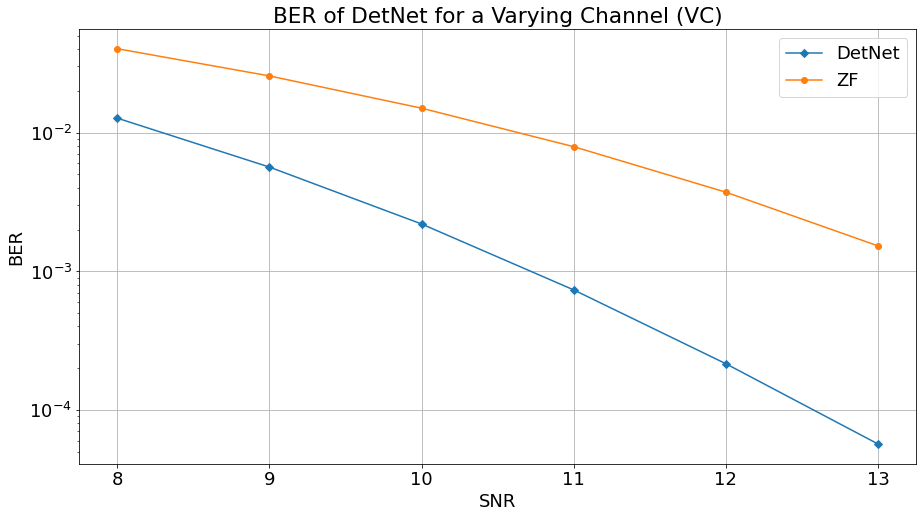

In [ ]:
# Plot BER curve.
fig = plt.figure(1,figsize=(15,8))
ber_res = np.mean(ber_test, axis=1)
ber_zf_res = np.mean(ber_zf_test, axis=1)
plt.figure(1,figsize=(15,8))
plt.rcParams.update({'font.size': 18})
plt.semilogy(snr_range, ber_res, marker='D')
plt.semilogy(snr_range, ber_zf_res, marker='o')
plt.legend(['DetNet', 'ZF'])
plt.grid(True)
plt.title("BER of DetNet for a Varying Channel (VC)")
plt.xlabel("SNR")
plt.ylabel("BER")
plt.show()
fig.savefig("DetNet_BER_ResNet.pdf", format='pdf',bbox_inches='tight')